In [1]:
import numpy as np
import PIL.Image as Image
import load
import augment
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
from monai.transforms import (
    Compose,
    NormalizeIntensityd,
    RandFlipd,
    RandAffined,
    RandSpatialCropd,
    SpatialPadd,
    ResizeWithPadOrCropd,
    RandRotated,
    SqueezeDimd,
    ToDeviced
)

In [3]:
aug_params = {
    "patch_size": (100,100,100),
    "final_size":   (100,100,100),
    "flip_prob":  0.5,
    "rot_prob":   1.0,
    "rot_range":  np.pi / 2
}

In [42]:
def rand_aug(
    src:torch.tensor,
    tgt:torch.tensor,
    aug_params=None,
    gpu:bool=True
):
    """
    Augment 3D volume and mask with cropping, normalization, padding, flipping, and rotation.
    The implementation allows for efficient data loading.
    Input should be memory mapped torch tensors on CPU

    Parameters:
        volume (np.ndarray): source 3D volume (shape: (C) x D x H x W). Channel optional.
        mask (np.ndarray): source 3D mask (shape: D x H x W).
    Returns:
        desc
    """
    device='cpu'
    if gpu: device='cuda'

    if len(src.shape) == 3: src = src.unsqueeze(0)
    if len(tgt.shape) == 3: tgt = tgt.unsqueeze(0)

    # Convert to tensors and move to the specified device
    sample = {"src": src, "tgt": tgt}

    keys = ["src", "tgt"]
    mode = ['trilinear', 'trilinear']

    augment = Compose([
        RandSpatialCropd(
            keys=keys, 
            roi_size=aug_params["patch_size"], 
            random_center=True, 
            random_size=False
        ),
        ToDeviced(
            keys=keys,
            device=device
        ),
        NormalizeIntensityd( # need in post processing
            subtrahend=torch.mean(sample['src']),
            divisor=torch.std(sample['src']),
            keys="src"), 
        RandFlipd(keys=keys, spatial_axis=[0, 1, 2], prob=aug_params["flip_prob"]),
        RandRotated(
            keys=keys, 
            range_x=aug_params["rot_range"], 
            # range_y=aug_params["rot_range"], 
            # range_z=aug_params["rot_range"], 
            prob=aug_params["rot_prob"],  
            keep_size=False,
            padding_mode='zeros',
            mode=mode
        ),
        ResizeWithPadOrCropd(
            keys=keys, 
            spatial_size=aug_params["final_size"], 
            method="symmetric",
            mode="constant"
        )
    ])
    
    return augment(sample)

In [5]:
#Get a sample

#Get the tomogram
tomo_path = os.path.join('..', 'data/train/tomo_0a8f05')
src = load.load_tomo(tomo_path)
#Get the heatmap
tgt = augment.get_heatmap(src.shape, [[52,587,575]], 30)

In [43]:
gpu = False
src = torch.Tensor(src).to(torch.float16)
tgt = torch.Tensor(tgt).to(torch.float16)
sample = rand_aug(src=src,
         tgt=tgt,
         aug_params=aug_params,
         gpu=gpu)

In [44]:
aug_params = {
    "patch_size": (100,100,100),
    "final_size":   (150,150,150),
    "flip_prob":  0.5,
    "rot_prob":   1.0,
    "rot_range":  np.pi / 2
}
sample = rand_aug(src=src,
         tgt=tgt,
         aug_params=aug_params,
         gpu=gpu)

metatensor(0.)


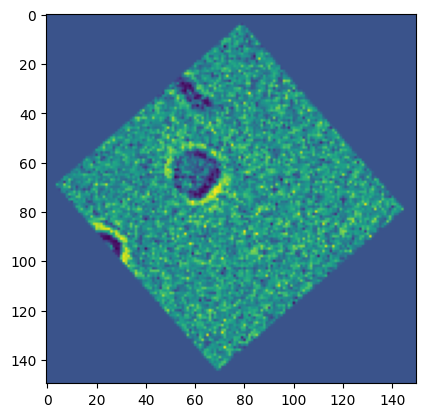

In [45]:
# sample = rand_aug(src=src,
#          tgt=tgt,
#          aug_params=aug_params,
#          gpu=gpu)
plt.imshow(sample['src'][0,50,:,:], cmap='viridis')
print(sample['tgt'].max())

In [30]:
df = pd.read_csv(os.path.join('..','data/train_labels.csv'))
# Assuming df is your DataFrame
df['Product'] = df['Array shape (axis 0)'] * df['Array shape (axis 1)'] * df['Array shape (axis 2)']
total_sum = df['Product'].sum()
print("Total bytes of dataset using fp16")
print(total_sum * 2)
kb = total_sum / 1024 * 2
print("kb: ", kb)
mb = kb / 1024
print("mb: ", mb)
gb = mb / 1024
print("gb: ", gb)

Total bytes of dataset using fp16
570717359432
kb:  557341171.3203125
mb:  544278.4876174927
gb:  531.5219605639577


In [25]:
tomo_path = os.path.join('..', 'data/train/tomo_0a8f05')
volume = load.load_tomo(tomo_path)

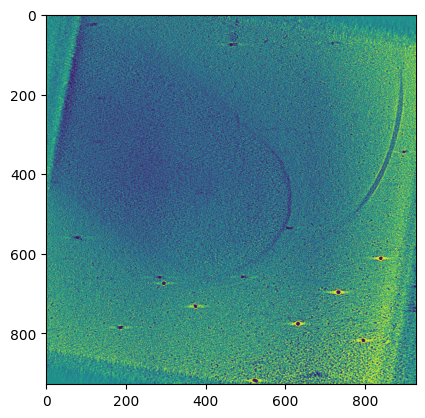

In [31]:
plt.imshow(volume[150, :, :], cmap="viridis")